In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#csvのパスを設定
csv_path = "/Users/ishigurofutoshi/lab_materials/data/integrated_route.csv"

missing_rate_path = "/Users/ishigurofutoshi/lab_materials/data/missing_rate_0.005.xlsx"

In [3]:
df = pd.read_csv(csv_path,index_col=0)
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]
df = df.dropna(axis=1)
date_time = pd.to_datetime(df.pop('5 Minutes'), format='%Y.%m.%d %H:%M').reset_index(drop=True)

In [4]:
target = "78"
n_input = 10
index_target = df.columns.get_loc(target)
n_min_ahead = 6
window_len = 24

In [5]:
df = df.reset_index(drop=True)

In [6]:
df

,11750,13147,13867,14467,14987,16207,16507,16509,16510,16511,...,79,80,81,82,83,84,85,86,87,88
0,16.88,34.90,8.62,19.35,7.00,21.43,30.88,30.22,35.87,40.30,...,30.15,29.38,36.30,35.93,11.78,11.87,16.80,16.73,15.92,12.12
1,16.97,34.87,8.65,19.35,7.00,21.42,30.87,29.98,35.92,40.37,...,30.15,29.37,36.37,35.88,11.82,11.88,16.80,16.78,15.87,12.12
2,16.98,34.95,8.67,19.38,7.00,21.43,30.82,30.07,36.02,40.43,...,30.17,29.27,36.23,35.88,11.82,12.07,16.83,16.77,15.85,12.15
3,16.98,35.05,8.67,19.43,7.02,21.37,30.85,30.15,36.13,40.55,...,30.15,29.13,36.27,35.98,11.82,11.92,16.82,16.70,15.83,12.18
4,16.90,35.03,8.68,19.53,7.03,21.40,30.88,30.28,36.27,40.68,...,29.97,29.02,36.37,36.08,11.85,11.92,16.83,16.73,15.88,12.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80095,17.15,35.30,8.60,19.42,7.22,21.57,30.62,30.30,36.15,40.72,...,30.65,30.08,36.03,36.00,11.78,12.03,16.82,17.02,15.52,12.78
80096,17.10,35.30,8.58,19.47,7.23,21.57,30.87,30.37,36.02,40.62,...,30.68,30.13,35.95,36.07,11.78,12.05,16.90,17.10,15.73,12.87
80097,17.32,35.28,8.60,19.43,7.22,21.82,31.45,31.00,36.17,40.82,...,30.52,30.03,36.02,35.98,11.82,12.00,16.87,17.17,15.63,12.78
80098,17.25,35.32,8.65,19.48,7.23,21.73,31.73,31.43,36.13,40.70,...,30.67,29.90,35.97,36.03,11.82,12.07,16.90,17.65,15.82,12.83


In [7]:
missing_rate_df = pd.read_excel(missing_rate_path)

### 標準化

In [8]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#train_df = df[0:int(n*0.9)]
#val_df = df[int(n*0.7):int(n*0.9)]
#test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
df_mean = df.mean()
df_std = df.std()

df = (df - df_mean) / df_std
#val_df = (val_df - train_mean) / train_std
#test_df = (test_df - train_mean) / train_std

In [10]:
def select_index(df,target):

    corrs = []
    for c in df.columns:
        corr = np.corrcoef(df[target],df[c])[0,1]
        corrs.append(corr)
    corrs = np.array(corrs)
    
    #重要度の上位を出力
    idx_corrs = np.argsort(np.abs(corrs))[::-1]
    top_cols_corrs,top_importances_corrs = df.columns.values[idx_corrs][:n_input],corrs[idx_corrs][:n_input]
    print(top_cols_corrs,top_importances_corrs)
    
    #targetのインデックスを追加
    if not target in top_cols_corrs:
        top_cols_corrs = np.append(top_cols_corrs,[target])
    
    top_cols_select = top_cols_corrs
    
    return top_cols_select


### 欠損生成&補完

In [11]:
select_features = select_index(df,target)

['78' '81' '275' '6225' '18830' '6224' '18828' '19835' '14467' '372'] [1.         0.93080856 0.9187865  0.91254206 0.91001707 0.90519843
 0.90467683 0.89662424 0.88076174 0.87273251]


In [12]:
#target not missing
df = df.loc[:,select_features]

In [13]:
labels_df_time = pd.concat((date_time,df.loc[:,target]),axis=1,sort=False)
inputs_df_time = pd.concat((date_time,df.loc[:,select_features]),axis=1,sort=False)

In [14]:
for i in labels_df_time.iloc[:int(80100*0.9)].loc[labels_df_time["5 Minutes"].dt.hour==0].sample(frac=0.5)[target].index:
    labels_df_time.loc[i,target] = 0

In [15]:
for t in range(24):
    for i in labels_df_time.iloc[:int(80100*0.9)].loc[labels_df_time["5 Minutes"].dt.hour==t].sample(frac=missing_rate_df[target][t]).index:
        labels_df_time.loc[i,target] = np.nan
    for route in select_features:
        for i in inputs_df_time.loc[inputs_df_time["5 Minutes"].dt.hour==t].sample(frac=missing_rate_df[route][t]).index:
            inputs_df_time.loc[i,route] = np.nan

In [16]:
inputs_df_time

,5 Minutes,78,81,275,6225,18830,6224,18828,19835,14467,372
0,2021-01-01 00:00:00,-0.806103,-0.762632,NaN,-0.697459,-0.690034,-0.775750,-0.777622,NaN,-0.870472,NaN
1,2021-01-01 00:05:00,-0.806103,-0.755430,-0.760267,NaN,-0.674737,-0.726482,-0.729137,-0.803569,-0.870472,NaN
2,2021-01-01 00:10:00,NaN,-0.769833,NaN,-0.661272,-0.663264,NaN,-0.723318,-0.760933,-0.864208,NaN
3,2021-01-01 00:15:00,NaN,-0.765718,-0.756951,NaN,-0.663264,-0.738307,-0.743682,-0.710176,NaN,NaN
4,2021-01-01 00:20:00,-0.806103,-0.755430,-0.743689,NaN,-0.673207,-0.753087,-0.758228,-0.752812,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
80095,2021-07-31 03:35:00,NaN,NaN,NaN,NaN,-0.699212,NaN,-0.672894,NaN,-0.855856,-0.840071
80096,2021-07-31 03:40:00,NaN,-0.798638,-0.737058,-0.693609,-0.696153,-0.671302,-0.670954,-0.864477,-0.845416,-0.837567
80097,2021-07-31 03:45:00,NaN,NaN,-0.745347,NaN,-0.665559,NaN,-0.697136,-0.831993,NaN,-0.832558
80098,2021-07-31 03:50:00,NaN,NaN,-0.753636,NaN,-0.645672,NaN,-0.689379,NaN,NaN,NaN


In [37]:
inputs_df = inputs_df_time.drop(["5 Minutes"],axis=1)
labels_df = labels_df_time.drop(["5 Minutes"],axis=1)

### MICE

#### ベイジアンリッジ

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True,tol=0.0001)
inputs_df = pd.DataFrame(imp.fit_transform(inputs_df))
labels_df = pd.DataFrame(imp.fit_transform(labels_df))

#### ガウジアンプロセスリグレッサー

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0)

imp = IterativeImputer(random_state=0,sample_posterior=True,estimator=gpr)
inputs_df = pd.DataFrame(imp.fit_transform(inputs_df))
labels_df = pd.DataFrame(imp.fit_transform(labels_df))

#### ランダムフォレスト

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)
imp = IterativeImputer(random_state=0,estimator=rf)
inputs_df = pd.DataFrame(imp.fit_transform(inputs_df))
labels_df = pd.DataFrame(imp.fit_transform(labels_df))

/Users/ishigurofutoshi/opt/anaconda3/envs/pems/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


In [39]:
inputs_df

,0,1,2,3,4,5,6,7,8,9
0,-0.806103,-0.762632,-0.726780,-0.697459,-0.690034,-0.775750,-0.777622,-0.894525,-0.870472,-0.858853
1,-0.806103,-0.755430,-0.760267,-0.679827,-0.674737,-0.726482,-0.729137,-0.803569,-0.870472,-0.833560
2,-0.790235,-0.769833,-0.729598,-0.661272,-0.663264,-0.724512,-0.723318,-0.760933,-0.864208,-0.833560
3,-0.779779,-0.765718,-0.756951,-0.667662,-0.663264,-0.738307,-0.743682,-0.710176,-0.656453,-0.691063
4,-0.806103,-0.755430,-0.743689,-0.675516,-0.673207,-0.753087,-0.758228,-0.752812,-0.802821,-0.806012
...,...,...,...,...,...,...,...,...,...,...
80095,-0.783961,-0.747097,-0.723299,-0.704234,-0.699212,-0.678594,-0.672894,-0.855341,-0.855856,-0.840071
80096,-0.815205,-0.798638,-0.737058,-0.693609,-0.696153,-0.671302,-0.670954,-0.864477,-0.845416,-0.837567
80097,-0.799583,-0.772713,-0.745347,-0.670280,-0.665559,-0.701356,-0.697136,-0.831993,-0.851680,-0.832558
80098,-0.794663,-0.748538,-0.753636,-0.649261,-0.645672,-0.689236,-0.689379,-0.794839,-0.779227,-0.791487


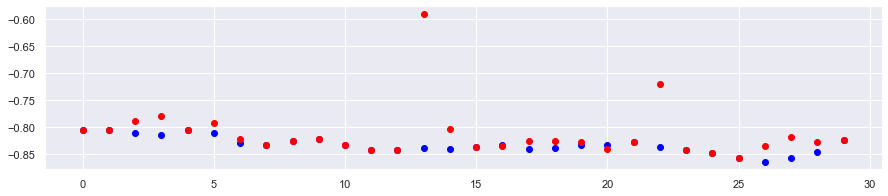

In [40]:
original = df["78"].values
imputation = inputs_df[0].values

plt.scatter(range(30),original[:30],color="blue")
plt.scatter(range(30),imputation[:30],color="red")

plt.show()

## データセット生成

In [41]:
def make_dataset(labels_df,inputs_df,window_len):
    labels, inputs = [], []
    for i in range(len(labels_df)-(window_len+n_min_ahead-1)):
        labels.append(labels_df.iloc[i+window_len+n_min_ahead-1])
        inputs.append(inputs_df.iloc[i:i+window_len])
    re_labels = np.array(labels).reshape(len(labels),1)
    re_inputs = np.array(inputs).reshape(len(inputs),window_len,n_input)
    
    return re_labels,re_inputs

In [42]:
labels_ds, inputs_ds = make_dataset(labels_df,inputs_df,window_len)

In [43]:
labels_ds.shape

(80071, 1)

In [44]:
inputs_ds.shape

(80071, 24, 10)

In [45]:
n = len(inputs_ds)
train_x, test_x = inputs_ds[:int(n*0.9)],inputs_ds[int(n*0.9):] 
train_y, test_y = labels_ds[:int(n*0.9)],labels_ds[int(n*0.9):]

In [46]:
# モデル構築

# 1つの学習データのwindowサイズ
length_of_sequence = inputs_ds.shape[1] 
in_out_neurons = 1
n_hidden = 300

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, n_input), return_sequences=False))
model.add(Dense(in_out_neurons))
#model.add(Activation("linear"))
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=5)
model.fit(train_x, train_y,
          batch_size=300,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping]
          )

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
216/217 [============================>.] - ETA: 0s - loss: 0.2052WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fa0f07b87a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

In [48]:
predicted = model.predict(test_x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


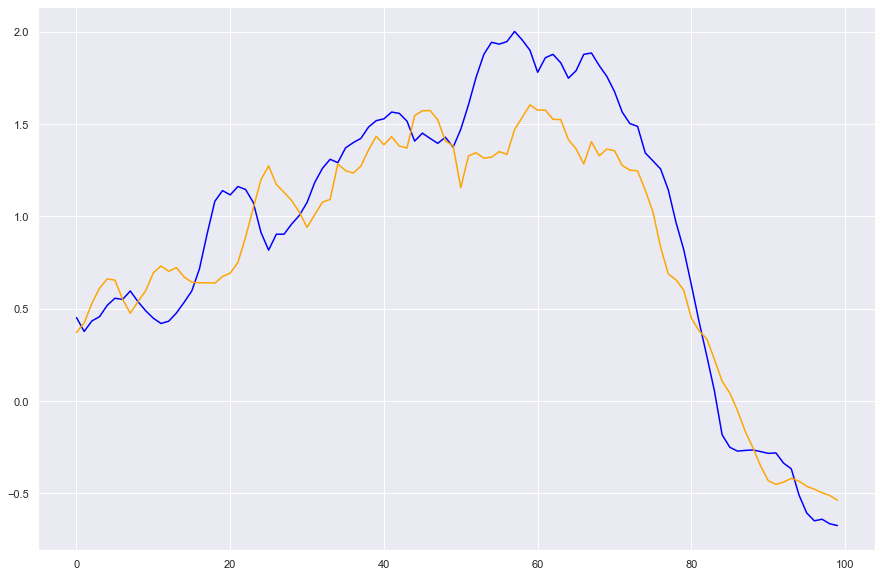

In [57]:
import itertools

plot_start = 900
plot_range = 100

plt.figure(figsize=(15,10))

plt.plot(test_y[plot_start:plot_start+plot_range],color="blue")
plt.plot(predicted[plot_start:plot_start+plot_range],color="orange")

NaN_position = [np.nan for i in range(len(test_y))]
measured_position = [np.nan for i in range(len(test_y))]
tmp = list(itertools.chain.from_iterable(test_y))

for i in range(len(test_y)):
    if np.isnan(labels_df_time.iloc[i,1]):
        NaN_position[i] = tmp[i]
    else:
        measured_position[i] = tmp[i]
        
#plt.scatter(list(range(plot_range)),NaN_position[plot_start:plot_start+plot_range],color="green",s=10)
#plt.scatter(list(range(plot_range)),measured_position[plot_start:plot_start+plot_range],color="red",s=10)

In [58]:
NaN_mask = [[0 for i in range(len(select_features))] for j in range(len(test_x[plot_start:plot_start+plot_range,:]))]

c_num = 0
for c in select_features:
    for i in range(len(test_x[plot_start:plot_start+plot_range,:])):
        if np.isnan(inputs_df_time[c].iloc[int(n*0.9)+plot_start+i,]):
            NaN_mask[i][c_num] = 1
    c_num += 1

NaN_mask = np.array(NaN_mask)
NaN_mask_df = pd.DataFrame(data=NaN_mask.T,index=select_features,columns=inputs_df_time["5 Minutes"].iloc[int(n*0.9)+plot_start:int(n*0.9)+plot_start+plot_range,].dt.strftime("%Y/%m/%d-%H:%M"))

<AxesSubplot:xlabel='5 Minutes'>

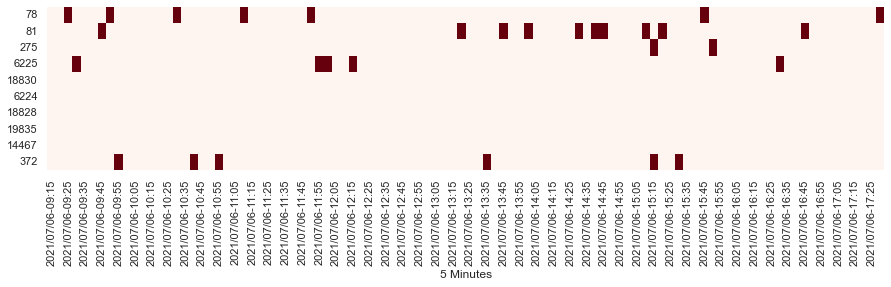

In [59]:
sns.set(rc={"figure.figsize":(15,3)})
sns.heatmap(NaN_mask_df,cmap="Reds",cbar=False)

In [52]:
performance = model.evaluate(test_x,test_y, verbose=0)

In [53]:
performance

0.18637578189373016